# Training RetinaNet

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib.util import find_spec
if find_spec("model") is None:
    import sys
    sys.path.append('..')

In [18]:
from fastai.vision.all import *
import torch.nn as nn
import matplotlib.cm as cmx
import matplotlib.colors as mcolors

In [4]:
from data_loader.data_loaders import load_sample_coco_dls
from model.backbone.fpn import FPN, retinanet_fpn_resnet
from model.model import retina_resnet50
from model.loss import RetinaLoss

# Load the Data 

In [5]:
dls = load_sample_coco_dls(bs=16)

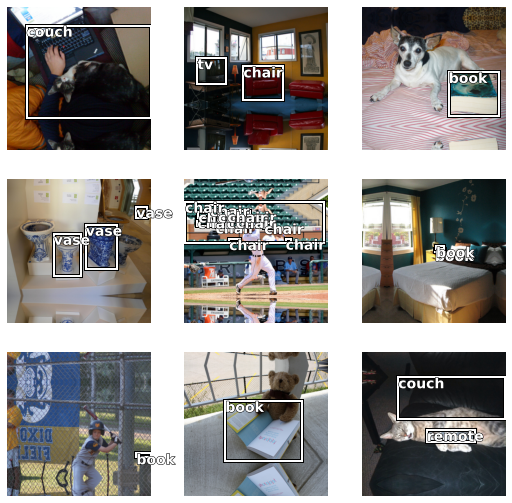

In [6]:
dls.show_batch()

# Build the Model

In [7]:
fpn_module = FPN(upsample_stages=[2048, 256], downsample_stages=[2048, 1024, 512])
fpn_module

FPN(
  (upsample_fpn3): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (upsample_fpn4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lat2): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
  (fpn2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lat1): LateralUpsampleMerge(
    (lat_conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (fpn1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lat0): LateralUpsampleMerge(
    (lat_conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (fpn0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
)

In [8]:
retina_fpn = retinanet_fpn_resnet()
retina_fpn

FPN(
  (upsample_fpn3): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (upsample_fpn4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lat2): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
  (fpn2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lat1): LateralUpsampleMerge(
    (lat_conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (fpn1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lat0): LateralUpsampleMerge(
    (lat_conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (fpn0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
)

## RetinaNet50

In [9]:
num_classes = 6

In [10]:
model = retina_resnet50(num_classes=num_classes)

# Focal Loss

## Allow Low Quality Matches

In [11]:
criterion = RetinaLoss(num_classes=num_classes)

Freeze everything except encoder (base arch).

In [12]:
def _retinanet_split(m): return L(m.base, nn.Sequential(m.backbone, m.head)).map(params)

In [13]:
learn = Learner(dls, model, loss_func=criterion, splitter=_retinanet_split)

In [14]:
learn.freeze()

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=6.309573450380412e-07)

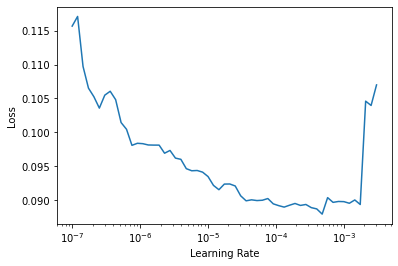

In [16]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,0.014137,0.013067,10:21
1,0.013715,0.012840,10:23
2,0.012587,0.013034,10:23
3,0.012674,0.011887,10:23
4,0.012781,0.011768,10:24
5,0.012216,0.011382,10:23
6,0.011208,0.011182,10:25
7,0.011190,0.011063,10:25
8,0.010684,0.011102,10:25
9,0.010879,0.010995,10:25


In [27]:
learn.save("coco_retina50")

Path('models/coco_retina50.pth')

## Don't Allow Low Quality Matches

In [8]:
criterion = RetinaLoss(num_classes=num_classes, , allow_low_quality_matches=False)

In [11]:
learn = Learner(dls, model, loss_func=criterion, splitter=_retinanet_split)

In [12]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,0.000000,0.000000,10:21
1,0.000000,0.000000,10:18


# Analyse Results

In [19]:
def get_cmap(N):
    color_norm = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap="Set3").to_rgba

num_colors = 6
cmap = get_cmap(num_colors)
color_list = [cmap(float(x)) for x in range(num_colors)]

In [ ]:
def show_img(im, figsize=None, axis=None):
    if not axis:
        fig.axis = plt.subplots(figsizeize)
    axis.imshow(im)
    axis.get_xaxis().set_visable(False)
    axis.get_yaxis().set_visable(False)
    return axis

def draw_outline(obj, lw):
    obj.set_path_effects([patheffects.Stroke(linewidth=lw, foreground="blank"), patheffects.Normal()])

def draw_rect(axis, box, color='white'):
    patch = axis.add_patch(patches.Rectangle(box[:2], box[-2], box[-1], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)